# Patient Classification: Medical Appointments

**The goal is to classify patient's medical appointment status based on his/her characteristics**
- No show: the response variable.  The patient did not show up 
- Age: age of patient
- Gender: gender of patient
- Diabetes: Patient has diabetes
- Alcoholism: Patient suffers from alcoholism
- HyperTension: Patient suffers from hypertension
- Handcap: Patient has handicap
- Scholarship: Patient receives financial aids
- Sms_Reminder: SMS was sent to patient as reminder
- Neighborhood:  Clinic location
- PatientID: Patient identifier
- AppointmentID: Appointment identifier
- ScheduledDay: The day/time in which the patient registered the appointment
- AppointmentDay: The day the patient actually came for appointment

**Data source**
- https://www.kaggle.com/joniarroba/noshowappointments

**Questions**
- Predict which patient will NOT show up to his/her appointment? This will help the clinic reassign doctors to other tasks/patients.

**Workflow**
- Data cleaning and formatting
- EDA
- Feature engineering and feature selection
- Split data into train and test datasets
- Baseline prediction
- Modelling, estimate test error with k-fold CV
- Select the best model based on a metric
- Optimize the model (tune hyperparameter)
- Return to Feature Engineering and Modelling if necessary
- Evaluate the final optimized model on the test dataset 
- Interpret the model results and draw conclusions

In [0]:
'''Data'''
import pandas as pd
import numpy as np
from scipy import stats
import itertools
import datetime
import calendar
import pprint

'''plots'''
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 15]

'''processing'''
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Import data

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/hfung4/datasets/master/medical_appointments.csv?token=AGVPHMFKKKQPPCU6SHE5TYC62LVJS")

In [0]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


# EDA

In [0]:
df.shape

(110527, 14)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [0]:
df.dtypes[df.dtypes=='O']

Gender            object
ScheduledDay      object
AppointmentDay    object
Neighbourhood     object
No-show           object
dtype: object

- Binary: Scholarship, Hipertension, Diabetes, Alcoholism, Handcap, SMS_received
- Cateogorical: Gender, Neighbourhood, No-show
- Continuous: Age
- Date: ScheduledDay, AppointmentDay
- Identifiers: PatientID, AppointmentID

In [0]:
df.isnull().sum() # no missing data

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

**Thoughts**
- All of the features seems to be useful in predictor No-show.  PatientID and AppointmentID can be used to see the number of appointments that I patient has (find out the number of appointmentID is associated with a patientID).  We also have to figure out a way to use ScheuldedDay and AppointmentDay  (maybe get DayoftheWeek and HoursoftheDay).

**Number of Distinct values for each column**
- I want to see if there is enough variations in my features 

In [0]:
col_unique = [(col,len(df.loc[:,col].unique())) for col in df.columns.values]
temp = pd.DataFrame(col_unique, columns=["features", "unique_count"]).sort_values(by="unique_count",ascending=False)
pprint.pprint(temp)

          features  unique_count
1    AppointmentID        110527
3     ScheduledDay        103549
0        PatientId         62299
5              Age           104
6    Neighbourhood            81
4   AppointmentDay            27
11         Handcap             5
2           Gender             2
7      Scholarship             2
8     Hipertension             2
9         Diabetes             2
10      Alcoholism             2
12    SMS_received             2
13         No-show             2


**Number of levels for my categorical features**

In [0]:
def level_counts(df,feature):
    count = df.loc[:, feature].value_counts(dropna =False)
    percent = round(df.loc[:,feature].value_counts(dropna=False, normalize=True)*100,2)
    # Put the series count and percent in an output DataFrame
    temp = pd.concat([count, percent], axis=1, keys=["count", "percent"])
    pprint.pprint(temp.iloc[:10,:])

In [0]:
level_counts(df,"Gender")

   count  percent
F  71840     65.0
M  38687     35.0


In [0]:
level_counts(df,"Neighbourhood")

                   count  percent
JARDIM CAMBURI      7717     6.98
MARIA ORTIZ         5805     5.25
RESISTÊNCIA         4431     4.01
JARDIM DA PENHA     3877     3.51
ITARARÉ             3514     3.18
CENTRO              3334     3.02
TABUAZEIRO          3132     2.83
SANTA MARTHA        3131     2.83
JESUS DE NAZARETH   2853     2.58
BONFIM              2773     2.51


In [0]:
level_counts(df,"No-show")

     count  percent
No   88208    79.81
Yes  22319    20.19


In [0]:
level_counts(df,"Handcap") # Handcap have 5 categories, perhaps 0 means no Handcap and 4 means very severe handicap

    count  percent
0  108286    97.97
1    2042     1.85
2     183     0.17
3      13     0.01
4       3     0.00


**Date data processing**

In [0]:
df[["ScheduledDay","AppointmentDay"]].sample(5)

,ScheduledDay,AppointmentDay
90665,2016-06-03T07:39:22Z,2016-06-03T00:00:00Z
417,2016-03-21T15:22:17Z,2016-04-29T00:00:00Z
77445,2016-05-05T07:10:22Z,2016-05-13T00:00:00Z
76444,2016-05-31T07:47:41Z,2016-05-31T00:00:00Z
86597,2016-06-02T16:31:28Z,2016-06-02T00:00:00Z


In [0]:
type(df.loc[0,"ScheduledDay"]), type(df.loc[0,"AppointmentDay"]) 

(str, str)

I need to convert from str to datetime objects for these columns.

In [0]:
data=df.copy()

In [0]:
data["ScheduledDay"] =pd.to_datetime(data["ScheduledDay"])
data["AppointmentDay"] =pd.to_datetime(data["AppointmentDay"])

**Find the Awaiting Time: the time gap between the patient register for his/her appointment and the time when he/she actually show up for the appointment**

In [0]:
data["AwaitingTime"] = data["AppointmentDay"]-data["ScheduledDay"]

**AppointmentDay has NO time component, so I want to find the time gap in terms of days**
- My hypothesis is that the longer the time gap, the more likely the patient will not show up.

In [0]:
data["AwaitingDays"] = data["AwaitingTime"].map(lambda x: x.days) 

**I am interested in the time of the day, and the day of the week in which the patient actually comes to the appointment.  I think that the day of the week (say during a workdaylike Monday to Thursday) would have more no shows.  Ideally, I also want to interact that with hours of the day, but unfortunately, we have no hours information for AppointmentDay.**

In [0]:
# Function  to find day of the week given a datetime
def findDay(date):
    return date.strftime("%A")

In [0]:
data["Appoint_Day_of_Week"] = data.AppointmentDay.map(lambda x: findDay(x))

## Univariate Analysis
- Use plots to find anomalies, patterns, and relationships
- Start with a high level overview of the data, then narrows in to specific features 

**Use barplots to look at all categorical variables**

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   PatientId            110527 non-null  float64            
 1   AppointmentID        110527 non-null  int64              
 2   Gender               110527 non-null  object             
 3   ScheduledDay         110527 non-null  datetime64[ns, UTC]
 4   AppointmentDay       110527 non-null  datetime64[ns, UTC]
 5   Age                  110527 non-null  int64              
 6   Neighbourhood        110527 non-null  object             
 7   Scholarship          110527 non-null  int64              
 8   Hipertension         110527 non-null  int64              
 9   Diabetes             110527 non-null  int64              
 10  Alcoholism           110527 non-null  int64              
 11  Handcap              110527 non-null  int64              
 12  SM

In [0]:
categorical_var = ["Appoint_Day_of_Week","No-show","SMS_received","Handcap","Alcoholism","Diabetes","Hipertension",
                "Scholarship","Gender"]

In [0]:
def categorical_barplots(var_list):
    plt.figure(figsize=(15,25))
    
    for i, var in enumerate(var_list): # var index and var name from var_list
        plt.subplot(7,2,i+1) 
        data[var].value_counts(normalize=True).plot(kind='bar', title=var)
        plt.ylabel("Proportion")
        plt.xticks(rotation='horizontal')
        # Tweak spacing to prevent clipping of tick-labels
        plt.subplots_adjust(bottom=-0.3)

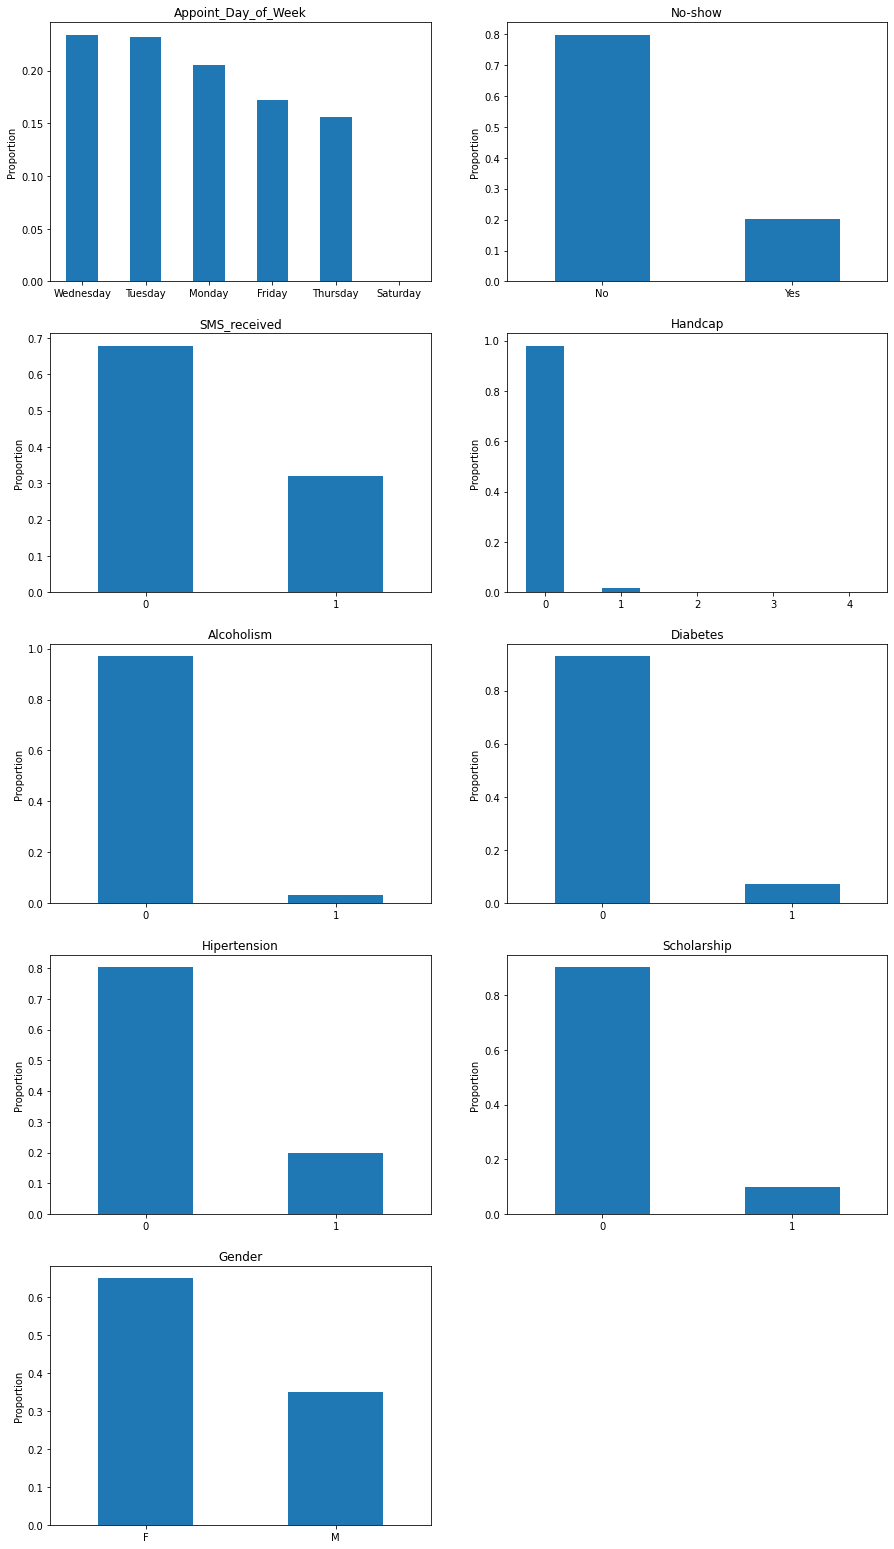

In [0]:
categorical_barplots(categorical_var)

- The clinic seems to be closed on Saturady and Sunday.  Monday to Wednesdays are the most popular appointment day of the week.
- 30% of the patients did not show up to their appointments.
- More than 60% of the patients are feamles.
- Only 20% has financial aid.
- 30% of the patients have SMS reminders.
- Only a very small proportion of people have handicaps, so this might not be a good predictor of no show.  It is not a binary variable but instead have 4 levels.

Since only a very small proportion of patients have handcap 2, 3, or 4, I will turn Handcap to a binary variable and set all patients with Handcap>=1 to 1.

In [0]:
data.loc[data["Handcap"]>=1,"Handcap"] = 1

In [0]:
data.Handcap.value_counts()

0    108286
1      2241
Name: Handcap, dtype: int64

**Let's look at the probability distribution of the continuous variables: AwaitingDays and Age**

In [0]:
cont_var = ["Age", "AwaitingDays"]

In [0]:
def continuous_kde(var_list):
    plt.figure(figsize=(8,15))
    for i, var in enumerate(var_list): # var index and var name from var_list
        plt.subplot(3,1,i+1) 
        sns.kdeplot(data=data.loc[:,var])
        plt.ylabel("f(x)")
        plt.xticks(rotation='horizontal')

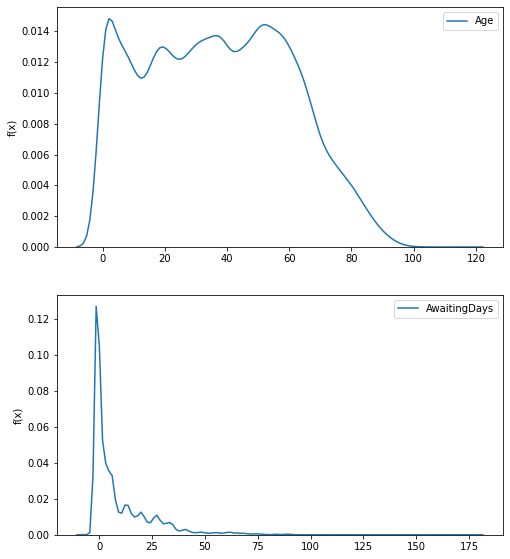

In [0]:
continuous_kde(cont_var)

- There is a small number of patients with negative age and negative AwaitingDays, which is not possible.
- The distribution of age is pretty uniform
- Some outliers in AwaitingDays
- A lot of patients reigster on the same date as their appointments

In [0]:
data.loc[data.AwaitingDays<0,"AwaitingDays"].sort_values()

71533    -7
55226    -2
72362    -2
27033    -2
64175    -2
         ..
39990    -1
39991    -1
39992    -1
39994    -1
110517   -1
Name: AwaitingDays, Length: 38568, dtype: int64

In [0]:
len(data.loc[data.AwaitingDays<0,"AwaitingDays"].sort_values())/len(data)

0.34894641128412063

34.9% of the data has negative AwaitingDays: the Appointment date is BEFORE the register date.

In [0]:
len(data.loc[data.AwaitingDays==-1,"AwaitingDays"].sort_values())/len(data)

0.34890117346892613

Almost all of them have AwaitingDays== -1

In [0]:
data.loc[data.AwaitingDays==-1,:].sample(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,AwaitingTime,AwaitingDays,Appoint_Day_of_Week
72487,8.356651e+13,5653960,M,2016-05-03 13:35:10+00:00,2016-05-03 00:00:00+00:00,67,ANDORINHAS,0,1,0,0,0,0,No,-1 days +10:24:50,-1,Tuesday
12327,1.843618e+14,5706914,M,2016-05-17 08:57:41+00:00,2016-05-17 00:00:00+00:00,41,MARIA ORTIZ,0,0,0,0,0,0,No,-1 days +15:02:19,-1,Tuesday
42606,4.215124e+13,5739832,M,2016-05-25 14:12:42+00:00,2016-05-25 00:00:00+00:00,15,MARIA ORTIZ,0,0,0,0,0,0,No,-1 days +09:47:18,-1,Wednesday
66159,6.722978e+12,5643144,M,2016-05-02 07:09:50+00:00,2016-05-02 00:00:00+00:00,6,JARDIM CAMBURI,0,0,0,0,0,0,Yes,-1 days +16:50:10,-1,Monday
88030,6.887996e+13,5776571,F,2016-06-06 11:25:01+00:00,2016-06-06 00:00:00+00:00,60,DA PENHA,0,1,0,0,0,0,No,-1 days +12:34:59,-1,Monday


**Since AppointmentDay has no time components (they all default to 00:00), for patients who made same-day appointments, they will have AwaitingDay of -1.  I will create a new dummy variable called "SameDayAppointment" and will set this variable to 1 for all patients with AwaitingDay =-1, and 0 otherwise.  I will also remove all patients with AwaitingDay <1.**

In [0]:
data["SameDayAppointment"] = 0
data.loc[data["AwaitingDays"]==-1,"SameDayAppointment"] = 1

In [0]:
data.loc[data["AwaitingDays"]==-1,"AwaitingDays"] = 0 # set all patients with AwaitingDays=-1 to AwaitingDays=0

In [0]:
data=data.loc[data["AwaitingDays"]>-1,:]

In [0]:
len(data.loc[data.Age<0,"Age"].sort_values())/len(data)

9.0479723493965e-06

Only a very small proporption of patients have negative age. I will therefore remove those patients.

In [0]:
data = data.loc[data.Age>=0,:]

In [0]:
data.shape

(110521, 18)

In [0]:
data.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'AwaitingTime', 'AwaitingDays', 'Appoint_Day_of_Week',
       'SameDayAppointment'],
      dtype='object')

## Outliers
- I remove Outliers that are above Q3+3*IQR for Awaiting time

In [0]:
def remove_outliers(df, feature):
    first_quartile = df.loc[:,feature].describe()["25%"]
    third_quartile = df.loc[:,feature].describe()["75%"]
    
    iqr = third_quartile - first_quartile
    lower_bound = first_quartile -3*iqr
    upper_bound = third_quartile+3*iqr
    
    # Remove outliers (only keep observations within IQR)
    df = df[(df.loc[:,feature]<upper_bound) & (df.loc[:,feature]>lower_bound)]
    print (lower_bound, upper_bound)
    return df

In [0]:
data=remove_outliers(data,"AwaitingDays")

-42.0 56.0


In [0]:
data=remove_outliers(data,"Age")

-97.0 169.0


## Are there patients with more than one appointments?

In [0]:
num_df = data.groupby("PatientId").size()

In [0]:
num_df

PatientId
3.921784e+04    1
4.374176e+04    1
9.377953e+04    1
1.417242e+05    1
5.376153e+05    1
               ..
9.999320e+14    5
9.999350e+14    1
9.999465e+14    1
9.999686e+14    1
9.999816e+14    1
Length: 61057, dtype: int64

In [0]:
# make num_df into a DataFrame
num_df = pd.DataFrame(num_df).reset_index()
num_df.columns=["PatientId", "num_appointments"]

In [0]:
# merge data and num_df
data = pd.merge(data,num_df, on="PatientId")

In [0]:
data.shape

(108055, 19)

In [0]:
data.loc[data["num_appointments"] ==5,:].head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,AwaitingTime,AwaitingDays,Appoint_Day_of_Week,SameDayAppointment,num_appointments
52,1.578132e+12,5637986,F,2016-04-29 07:35:56+00:00,2016-04-29 00:00:00+00:00,64,TABUAZEIRO,1,1,1,0,0,0,No,-1 days +16:24:04,0,Friday,1,5
53,1.578132e+12,5744352,F,2016-05-30 10:08:12+00:00,2016-05-30 00:00:00+00:00,64,TABUAZEIRO,1,1,1,0,0,0,No,-1 days +13:51:48,0,Monday,1,5
54,1.578132e+12,5639322,F,2016-04-29 08:57:23+00:00,2016-05-06 00:00:00+00:00,64,TABUAZEIRO,1,1,1,0,0,0,Yes,6 days 15:02:37,6,Friday,0,5
55,1.578132e+12,5714366,F,2016-05-18 11:48:23+00:00,2016-05-30 00:00:00+00:00,64,TABUAZEIRO,1,1,1,0,0,0,Yes,11 days 12:11:37,11,Monday,0,5
56,1.578132e+12,5743058,F,2016-05-30 08:39:14+00:00,2016-05-30 00:00:00+00:00,64,TABUAZEIRO,1,1,1,0,0,0,No,-1 days +15:20:46,0,Monday,1,5


## Label Encoding
- Need to encode the nominal variables (order does not matter): Gender, No-Show, Appoint_Day_of_Week
- No-show: No = 0, Yes =1
- Gender: Female =0, Male =1
- Appoint_Day_of_Week

In [0]:
data_copy = data.copy() # save a copy of data

In [0]:
nom_var = ["No-show", "Gender"]

In [0]:
from sklearn.preprocessing import LabelEncoder
# init the label encoder
le = LabelEncoder()
# encode the nominal variables
data[nom_var]=data[nom_var].apply(lambda x: le.fit_transform(x), axis=0)

In [0]:
mapping_dict = {'Monday' : 1, 'Tuesday' : 2, 'Wednesday' : 3, 'Thursday' : 4,
'Friday' : 5, 'Saturday' : 6, 'Sunday' : 7}
data['Appoint_Day_of_Week'] = data['Appoint_Day_of_Week'].map(mapping_dict)

## Bivariate Analysis

**No-Show vs Age**

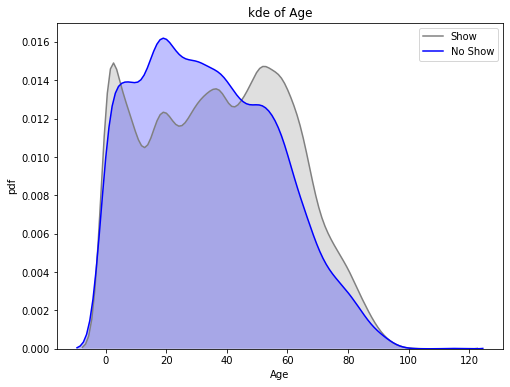

In [0]:
fig = plt.figure(figsize=(8,6))
sns.kdeplot(data=data.loc[data["No-show"]==0,"Age"],
            color='gray',
            shade='True',
            label="Show")

sns.kdeplot(data=data.loc[data["No-show"]==1,"Age"],
            color='blue', 
            shade=True,
            label="No Show")

plt.title("kde of Age")            
plt.xlabel("Age", fontsize=10)            
plt.ylabel("pdf", fontsize=10)   
plt.show()

- Adults between 18-50 seems to be more likely of no Show.
- The Elderly (age >55) have higher chance of show up)

**No-Show vs number of appointments**

Text(0, 0.5, 'pdf')

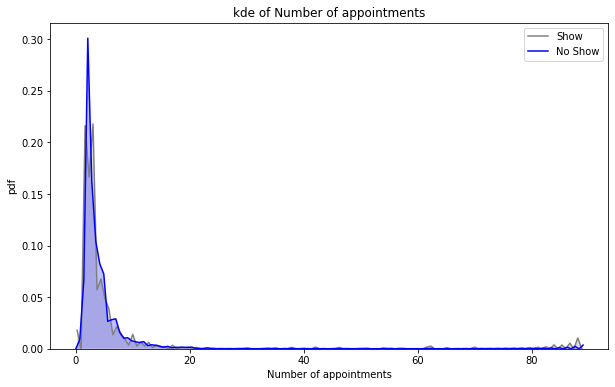

In [0]:
fig = plt.figure(figsize=(10,6))
sns.kdeplot(data=data.loc[data["No-show"]==0,"num_appointments"],
            color='gray',
            shade='True',
            label="Show")

sns.kdeplot(data=data.loc[data["No-show"]==1,"num_appointments"],
            color='blue', 
            shade=True,
            label="No Show")

plt.title("kde of Number of appointments")            
plt.xlabel("Number of appointments", fontsize=10)            
plt.ylabel("pdf", fontsize=10) 

## Barplot for categorical variables vs No-show

In [0]:
categorical_var = ["Appoint_Day_of_Week","SameDayAppointment","SMS_received","Handcap","Alcoholism","Diabetes","Hipertension",
                   "Scholarship","Gender"]

In [0]:
def categorical_barplots(var_list):
    plt.figure(figsize=(15,25))
    
    for i, var in enumerate(var_list): # var index and var name from var_list
        plt.subplot(7,2,i+1) 
        sns.barplot(y="No-show", x=var, data=data,
           capsize=0.05, #width of "cap"on errorbars
           linewidth=5)
        plt.ylabel("Proportion of patient who did not Show")
        plt.xlabel(var, fontsize=8)
        plt.xticks(rotation='horizontal')
        # Tweak spacing to prevent clipping of tick-labels
        plt.subplots_adjust(bottom=-0.3)

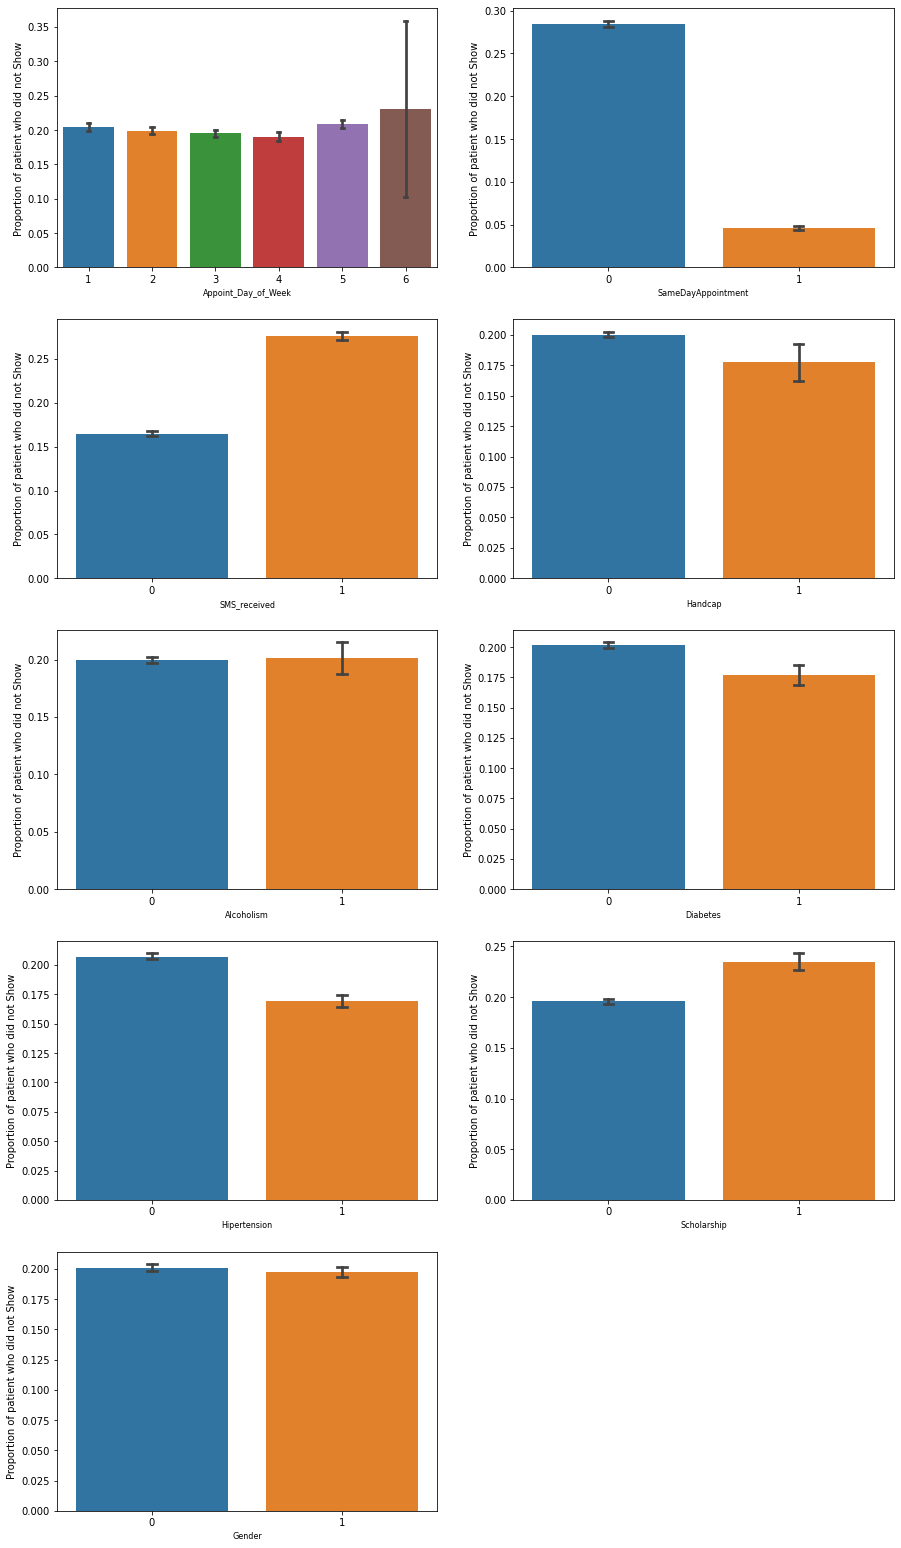

In [0]:
categorical_barplots(categorical_var)

- A high amount of variance in No show for patients whose appointment is on Saturday.  Friday and Saturday has slightly higher No shows.
- Patients with Same-day appointments are likely urgent cases so they have a low proportion of No-shows.
- Surprisely, people who received SMS and financial aid has higher proportion of No Shows.  
- Handicap, Hipertension, and Diabetes patients has less chance of No-show.
- Gender have same amount of Shows and No-Shows.

## Pair Grid (for continuous variables)
- A matrix of plots that allow us to see the relationships between the features and between the feature and the response.
- We will only plot a subset of variables that are of interest.

In [0]:
cont_var = ["Age", "AwaitingDays", "num_appointments"]

In [0]:
plot_data = data[cont_var]

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1259: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


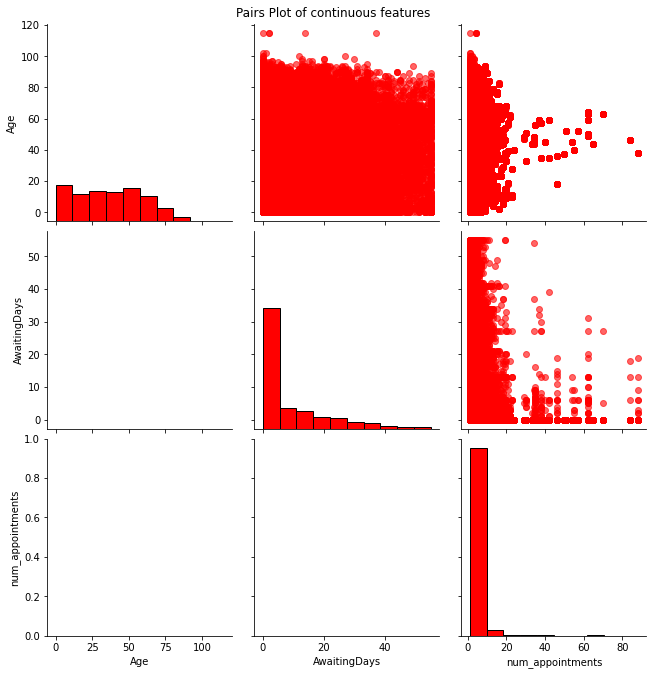

In [0]:
# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3)
# Upper is a scatter plot
grid.map_upper(plt.scatter, color = 'red', alpha = 0.6)
# Diagonal is a histogram
grid.map_diag(plt.hist, color = 'red', edgecolor = 'black')
# Title for entire plot
plt.suptitle('Pairs Plot of continuous features', size = 12, y = 1.02);

In [0]:
correlations_1 = data[['Age', 'AwaitingDays']].corr(method='spearman')

In [0]:
correlations_2 = data[['Age', 'num_appointments']].corr(method='spearman')

In [0]:
correlations_3 = data[['AwaitingDays', 'num_appointments']].corr(method='spearman')

In [0]:
correlations_1

,Age,AwaitingDays
Age,1.000000,0.006955
AwaitingDays,0.006955,1.000000


In [0]:
correlations_2

,Age,num_appointments
Age,1.000000,0.034635
num_appointments,0.034635,1.000000


In [0]:
correlations_3

,AwaitingDays,num_appointments
AwaitingDays,1.000000,-0.063511
num_appointments,-0.063511,1.000000


Therefore, no correlations amongest the continuous variables.

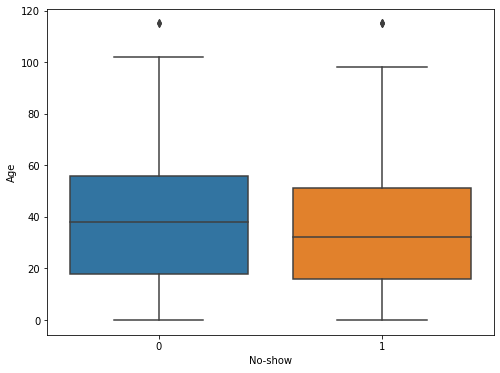

In [0]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(y="Age", x="No-show", data= data)

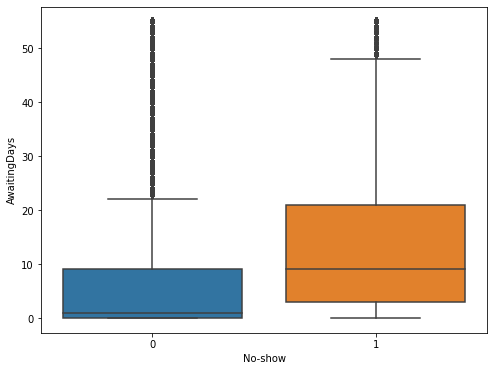

In [0]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(y="AwaitingDays", x="No-show", data= data)

- The boxplots show that the average age of patients who did not show up is younger than patients who showed up.
- The average gap between registration and appointment is higher for patients who did not show up.

## Cramer's V for Categorical-Categorical Correlations
- https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792

In [0]:
import scipy.stats as ss

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [0]:
def get_categorical_corr(df,X,Y):
    confusion_matrix = pd.crosstab(df.loc[:,X], df.loc[:,Y]).to_numpy() # use to_numpy instead of as_matrix
    cram_V = round(cramers_v(confusion_matrix),4)
    if cram_V > 0.2:
        print("The Cramer's V of {} and {} is {}".format(X,Y,cram_V))

In [0]:
categorical_var = ["Appoint_Day_of_Week","SameDayAppointment","SMS_received","Handcap","Alcoholism","Diabetes","Hipertension",
                   "Scholarship","Gender", "No-show"]

In [0]:
categorical_pairs = list(itertools.combinations(categorical_var,2))

In [0]:
# Only print Cramer's V if it is above 0.2
for x,y in categorical_pairs:
    get_categorical_corr(data,x,y)

The Cramer's V of SameDayAppointment and SMS_received is 0.5037
The Cramer's V of SameDayAppointment and No-show is 0.2855
The Cramer's V of Diabetes and Hipertension is 0.4333


**No strong relationships between features and between features and the response.**

## One hot encode the nominal variable "Neighbourhood"

In [0]:
dummy_df = pd.get_dummies(data["Neighbourhood"], drop_first=True)
dummy_df.shape

(108055, 80)

In [0]:
# Drop features that I think are not needed
processed = data.drop(["PatientId","AppointmentID","ScheduledDay","AppointmentDay","AwaitingTime","Neighbourhood"], axis=1)

In [0]:
processed = pd.concat([processed, dummy_df], axis=1)

## Split Data into train and test datasets

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [0]:
X = processed.drop("No-show", axis=1)

In [0]:
y = processed["No-show"]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 101, stratify=y)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((75638, 92), (32417, 92), (75638,), (32417,))

## Baseline Prediction
- For classification problem, we predict the class value that is most common in the train dataset.

In [0]:
y_train.value_counts().sort_values(ascending=False)

0    60531
1    15107
Name: No-show, dtype: int64

Since in my train dataset, No-show = 0 is the most frequent class, I predict No-show=0 for all observations in my baseline model.

In [0]:
baseline_pred = np.zeros(len(y_test))

In [0]:
accuracy_score(baseline_pred,y_test)

0.8002899713113489

**My baseline accuracy_score is 0.80**

# Modelling
- I will use grid search to optimize models built from a number of different types estimators, which we will then compare and properly evaluate the best hyperparameters that each model has to offer.
- I will use pipeline:
    - Step 1: Scaling the features: Scaling is sometimes necessary because features are in different units, and we want to normalize the features so the units do not affect the algorithm. Linear Regression and Random Forest do not require feature scaling, but other methods, such as support vector machines and k nearest neighbors, do require it because they take into account the Euclidean distance between observations. For this reason, it is a best practice to scale features when we are comparing multiple algorithms.
    - Step 2: Use PCA to get a lower-dimension representation of the features (to reduce the complexity/flexibility of the model)
    - Step 3: Train the estimator: Fit the scaled data to a model.
- Use GridSearchCV to find the best hyperparameter for each model.
- Select the best model.  

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

**Construct some pipelines**

In [0]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(random_state=42))]) # pipeline for logreg

pipe_lr_pca = Pipeline([('scl', StandardScaler()),
                        ('pca', PCA(n_components=2)), # use default n_components for now, we will need to tune this parameter
                        ('clf', LogisticRegression(random_state=42))]) # pipeline for logreg with pca

In [0]:
pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestClassifier(criterion = 'gini', min_samples_leaf = 1,
                                                   min_samples_split = 2, random_state=42))]) # pipeline for random forest classifier

pipe_rf_pca = Pipeline([('scl', StandardScaler()),
                        ('pca', PCA(n_components=2)),
                        ('clf', RandomForestClassifier(random_state=42))]) # pipeline for random forest with pca

In [0]:
pipe_ab = Pipeline([('scl', StandardScaler()),
                     ('clf', AdaBoostClassifier(random_state=42))]) # pipeline for adaboost

pipe_ab_pca = Pipeline([('scl', StandardScaler()),
                         ('pca', PCA(n_components=2)),
                         ('clf', AdaBoostClassifier(random_state=42))])  # pipeline for adaboost with PCA

**Set the grid search parameters**

In [0]:
grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
                   'clf__C': [0.1,0.5,1],
                   'clf__solver': ['liblinear']}] 

grid_params_rf = [{'clf__n_estimators': [20,21,22],
                   'clf__max_depth': [22,24,25]}]

grid_params_ab = [{'clf__n_estimators': [1,3,5], 
                    'clf__learning_rate': [0.001,0.01]}]

**Grid search models**

In [0]:
num_jobs = -1 # use all processors

In [0]:
gs_lr = GridSearchCV(estimator=pipe_lr,
                     param_grid=grid_params_lr,
                     scoring='f1',
                     cv=10,
                     n_jobs = num_jobs)
                     
gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
                         param_grid=grid_params_lr,
                         scoring='f1',
                         cv=10)

In [0]:
gs_rf = GridSearchCV(estimator=pipe_rf,
                     param_grid=grid_params_rf,
                     scoring='f1',
                     cv=10,
                     n_jobs=num_jobs,
                     verbose=2) 

gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
                         param_grid=grid_params_rf,
                         scoring='f1',
                         cv=10,
                         n_jobs=num_jobs,
                         verbose=2)

In [0]:
gs_ab = GridSearchCV(estimator=pipe_ab,
                     param_grid=grid_params_ab,
                     scoring='f1',
                     cv=10,
                     n_jobs=num_jobs,
                     verbose=2) 

gs_ab_pca = GridSearchCV(estimator=pipe_ab_pca,
                         param_grid=grid_params_ab,
                         scoring='f1',
                         cv=10,
                         n_jobs=num_jobs,
                         verbose=2)

In [0]:
# List of pipelines for iteration
grids = [gs_lr_pca,
         gs_rf,
         gs_ab]

In [0]:
grids = [gs_lr_pca,gs_rf,gs_ab]

In [0]:
# Dictionary of pipelines and type of classifier for reference
grid_dict = {0: 'Logistic Regression with PCA', 1: 'Random Forest', 2:'Adaboost'}

In [0]:
# Train the grid search models

print('Training...')

# init the "best" variables
best_f1 = 0.0
best_clf_index = 0
best_gs = ''

for i, gs in enumerate(grids):
    print("\nEstimator: {}".format(grid_dict[i])) # classifier name
    
    # fit grid search
    gs.fit(X_train, y_train)
    
    # Get best parameters
    print("Best parameters are: {}".format(gs.best_params_))
    
    # Best estimated test accuracy score (CV)
    print("Best estimated test f1: {}".format(gs.best_score_))
    
    # test predictions 
    y_pred = gs.predict(X_test)
    
    # Test data accuracy and f1 of model with best parameters
    print("Accuracy score for model with best parameters (Test dataset): {}".format(accuracy_score(y_test, y_pred)))
    print("f1 score for model with best parameters (Test dataset): {}".format(f1_score(y_test, y_pred)))
    
    # Record best model with highest accuracy score
    if f1_score(y_test, y_pred) > best_f1:
        best_f2 = f1_score(y_test, y_pred) # update best accuracy score
        best_gs = gs  # update model
        best_clf_index = i

# Print final results
print("\nClassifier with best test set f1: {}".format(grid_dict[best_clf_index]))

# Save best grid search pipeline to file
#dump_file = 'best_gs_pipeline.pkl'
#joblib.dump(best_gs, dump_file, compress=1)
#print('\nSaved %s grid search pipeline to file: {}'.format(grid_dict[best_clf_index], dump_file))
    

Training...

Estimator: Logistic Regression with PCA
Best parameters are: {'clf__C': 1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best estimated test f1: 0.011921213065966493
Accuracy score for model with best parameters (Test dataset): 0.7983465465650739
f1 score for model with best parameters (Test dataset): 0.012985052091197342

Estimator: Random Forest
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.9min finished


Best parameters are: {'clf__max_depth': 25, 'clf__n_estimators': 20}
Best estimated test f1: 0.11029528760872451
Accuracy score for model with best parameters (Test dataset): 0.8026961162353087
f1 score for model with best parameters (Test dataset): 0.11314475873544093

Estimator: Adaboost
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   21.8s finished


Best parameters are: {'clf__learning_rate': 0.001, 'clf__n_estimators': 1}
Best estimated test f1: 0.0
Accuracy score for model with best parameters (Test dataset): 0.8002899713113489
f1 score for model with best parameters (Test dataset): 0.0

Classifier with best test set f1: Random Forest


In [0]:
best_gs.best_score_ # VERY low

0.11029528760872451

In [0]:
final_model= best_gs.best_estimator_

Classification Report

In [0]:
print(classification_report(y_test,final_model.predict(X_test)))  

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     25943
           1       0.55      0.06      0.11      6474

    accuracy                           0.80     32417
   macro avg       0.68      0.53      0.50     32417
weighted avg       0.76      0.80      0.73     32417



- The ccuracy score is no better than the baseline model, recall for 1 is close to 0.  This means due to the large number of class 0 observations, almost all of the predictions of class 1 made by the model is wrong! 

## Feature Importance

In [0]:
importances = final_model["clf"].feature_importances_
names = list(X.columns.values)
feature_ranked = (sorted(zip(map(lambda x: round(x, 4), importances), names), 
             reverse=True))
print(feature_ranked)

[(0.2305, 'AwaitingDays'), (0.2203, 'Age'), (0.133, 'SameDayAppointment'), (0.1066, 'num_appointments'), (0.0793, 'Appoint_Day_of_Week'), (0.0252, 'Gender'), (0.0229, 'SMS_received'), (0.0151, 'Hipertension'), (0.0108, 'Scholarship'), (0.009, 'Diabetes'), (0.0084, 'Alcoholism'), (0.0055, 'Handcap'), (0.0047, 'ITARARÉ'), (0.0036, 'JESUS DE NAZARETH'), (0.0035, 'GURIGICA'), (0.0032, 'SANTO ANDRÉ'), (0.0032, 'RESISTÊNCIA'), (0.0032, 'CARATOÍRA'), (0.0031, 'ILHA DO PRÍNCIPE'), (0.0029, 'SÃO PEDRO'), (0.0029, 'SÃO JOSÉ'), (0.0029, 'SANTOS DUMONT'), (0.0028, 'ANDORINHAS'), (0.0026, 'MARIA ORTIZ'), (0.0026, 'BONFIM'), (0.0025, 'SANTO ANTÔNIO'), (0.0025, 'BELA VISTA'), (0.0024, 'TABUAZEIRO'), (0.0024, 'SÃO BENEDITO'), (0.0024, 'JARDIM DA PENHA'), (0.0024, 'DO QUADRO'), (0.0024, 'DA PENHA'), (0.0023, 'ROMÃO'), (0.0023, 'JARDIM CAMBURI'), (0.0023, 'ILHA DAS CAIEIRAS'), (0.0022, 'SANTA MARTHA'), (0.0022, 'MARUÍPE'), (0.0021, 'SANTA TEREZA'), (0.0021, 'NOVA PALESTINA'), (0.0021, 'ILHA DE SANTA MAR

## Thoughts:
- The f1 score is very low 0.11 and the recall for the minority class (class 1) is close to 0.  This is because the dataset is imbalaced-- there are a lot more people who DID not missed appointment than those that did.

- I can up-sample the minority class and rerun model with only the 15 most important features.  With no additional information about the neighbourhoods, perhaps I can omit most of the dummies from the model.  

## **Second Iteration**

In [0]:
feature_ranked=[(0.2305, 'AwaitingDays'), (0.2203, 'Age'), (0.133, 'SameDayAppointment'), (0.1066, 'num_appointments'), (0.0793, 'Appoint_Day_of_Week'), (0.0252, 'Gender'), (0.0229, 'SMS_received'), (0.0151, 'Hipertension'), (0.0108, 'Scholarship'), (0.009, 'Diabetes'), (0.0084, 'Alcoholism'), (0.0055, 'Handcap'), (0.0047, 'ITARARÉ'), (0.0036, 'JESUS DE NAZARETH'), (0.0035, 'GURIGICA'), (0.0032, 'SANTO ANDRÉ'), (0.0032, 'RESISTÊNCIA'), (0.0032, 'CARATOÍRA'), (0.0031, 'ILHA DO PRÍNCIPE'), (0.0029, 'SÃO PEDRO'), (0.0029, 'SÃO JOSÉ'), (0.0029, 'SANTOS DUMONT'), (0.0028, 'ANDORINHAS'), (0.0026, 'MARIA ORTIZ'), (0.0026, 'BONFIM'), (0.0025, 'SANTO ANTÔNIO'), (0.0025, 'BELA VISTA'), (0.0024, 'TABUAZEIRO'), (0.0024, 'SÃO BENEDITO'), (0.0024, 'JARDIM DA PENHA'), (0.0024, 'DO QUADRO'), (0.0024, 'DA PENHA'), (0.0023, 'ROMÃO'), (0.0023, 'JARDIM CAMBURI'), (0.0023, 'ILHA DAS CAIEIRAS'), (0.0022, 'SANTA MARTHA'), (0.0022, 'MARUÍPE'), (0.0021, 'SANTA TEREZA'), (0.0021, 'NOVA PALESTINA'), (0.0021, 'ILHA DE SANTA MARIA'), (0.0021, 'GRANDE VITÓRIA'), (0.0021, 'CENTRO'), (0.002, 'JABOUR'), (0.002, 'FORTE SÃO JOÃO'), (0.0019, 'PRAIA DO SUÁ'), (0.0019, 'CRUZAMENTO'), (0.0018, 'SÃO CRISTÓVÃO'), (0.0018, 'REDENÇÃO'), (0.0018, 'JOANA D´ARC'), (0.0016, 'PRAIA DO CANTO'), (0.0016, 'INHANGUETÁ'), (0.0016, 'CONSOLAÇÃO'), (0.0016, 'BENTO FERREIRA'), (0.0015, 'FONTE GRANDE'), (0.0015, 'CONQUISTA'), (0.0014, 'VILA RUBIM'), (0.0014, 'SANTOS REIS'), (0.0014, 'SANTA CLARA'), (0.0014, 'REPÚBLICA'), (0.0014, 'PARQUE MOSCOSO'), (0.0014, 'GOIABEIRAS'), (0.0013, 'ESTRELINHA'), (0.0013, 'DO MOSCOSO'), (0.0012, 'MÁRIO CYPRESTE'), (0.0012, 'DO CABRAL'), (0.0011, 'SANTA CECÍLIA'), (0.0011, 'MONTE BELO'), (0.001, 'SANTA LUÍZA'), (0.001, 'PIEDADE'), (0.001, 'JUCUTUQUARA'), (0.0009, 'MATA DA PRAIA'), (0.0009, 'ENSEADA DO SUÁ'), (0.0009, 'BOA VISTA'), (0.0008, 'SANTA LÚCIA'), (0.0008, 'COMDUSA'), (0.0008, 'BARRO VERMELHO'), (0.0007, 'SOLON BORGES'), (0.0007, 'DE LOURDES'), (0.0007, 'ARIOVALDO FAVALESSA'), (0.0006, 'SEGURANÇA DO LAR'), (0.0006, 'HORTO'), (0.0006, 'FRADINHOS'), (0.0006, 'ANTÔNIO HONÓRIO'), (0.0005, 'UNIVERSITÁRIO'), (0.0005, 'SANTA HELENA'), (0.0005, 'MORADA DE CAMBURI'), (0.0004, 'NAZARETH'), (0.0003, 'PONTAL DE CAMBURI'), (0.0001, 'ILHAS OCEÂNICAS DE TRINDADE'), (0.0001, 'ILHA DO FRADE'), (0.0001, 'ILHA DO BOI'), (0.0, 'PARQUE INDUSTRIAL')]

In [0]:
temp =list(zip(*feature_ranked))[1]

In [0]:
top_features= list(temp[:15])
top_features.append("No-show")

**Include only the top 15 most important features in the new model**

In [0]:
processed_new = processed[top_features]
X = processed_new.drop("No-show", axis=1)
y= processed_new["No-show"]

**Up-sample the minority class (No-show = 1)**
- Use ADASYN
- https://medium.com/coinmonks/smote-and-adasyn-handling-imbalanced-data-set-34f5223e167



In [301]:
from imblearn.over_sampling import ADASYN
X_resampled, y_resampled = ADASYN().fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**Train test split**

In [304]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_resampled, y_resampled, test_size= 0.3, random_state= 101, shuffle=True)
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((124132, 15), (53200, 15), (124132,), (53200,))

Focus only on Random Forest in this iteration

In [0]:
pipe_rf2 = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestClassifier(criterion = 'gini', min_samples_leaf = 1, 
                                                   min_samples_split =2, random_state=42))]) # pipeline for random forest classifier

In [0]:
grid_params_rf2 = [{'clf__n_estimators': [10,20,30,40],
                   'clf__max_depth': [40,50,60,70]}]

In [0]:
gs_rf2 = GridSearchCV(estimator=pipe_rf2,
                     param_grid=grid_params_rf2,
                     scoring='f1',
                     cv=10,
                     n_jobs=num_jobs,
                     verbose=2) 

In [312]:
# fit grid search
gs_rf2.fit(X_train2, y_train2)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  6.6min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scl',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                

In [313]:
gs_rf2.best_params_

{'clf__max_depth': 40, 'clf__n_estimators': 40}

In [314]:
gs_rf2.best_score_ # best estimated test f1 score (a large improvement from the model in the first iteration)

0.7896435684465516

In [0]:
y_pred=gs_rf2.best_estimator_["clf"].predict(X_test2)

In [0]:
print(classification_report(y_test2, y_pred)) 

              precision    recall  f1-score   support

           0       0.63      0.72      0.67     26115
           1       0.69      0.59      0.64     27253

    accuracy                           0.65     53368
   macro avg       0.66      0.65      0.65     53368
weighted avg       0.66      0.65      0.65     53368



### **Thoughts**

Compared to the first model, the accuracy score is lower, but recall and precison for class 1 (the minority class), which was close to 0 in the first model, has greatly improved.